# Transformer
Working from [this](https://github.com/jacobhilton/deep_learning_curriculum/blob/master/1-Transformers.md)

## Initial Questions

1. What is different architecturally from the Transformer, vs a normal RNN, like an LSTM? (Specifically, how are recurrence and time managed?)
    
    No recurrance, time uses positional embeddings, self attention.

2. Attention is defined as, $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$. What are the dimensions for Q, K, and V? Why do we use this setup? What other combinations could we do with (Q,K) that also output weights?

  $\text{seq_length} \times d_k, d_k, d_v$

  So $QK^T$ is a $(\text{seq_length}, \text{seq_length})$ matrix and Attention is a $(\text{seq_length}, d_v)$ matrix
  
  But MultiHead attention is defined as
  
  $\text{MultiHeadAttention}(Q, K, V) = \text{concat}(\text{head}_1, \text{head}_2, \ldots)W_0$
  
  These heads are defined as
  
  $\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^Q)$
  
  Where
  
  $W_i^Q \in \mathbb{R}^{d_\text{model}\times d_k}, W_i^K \in \mathbb{R}^{d_\text{model}\times d_k} , W_i^V \in \mathbb{R}^{d_\text{model}\times d_v}$ and $W_O \in \mathbb{R}^{hd_v\times d_\text{model}}$.
  
  This means working backward that for multi headed attention
  
  $Q, K, \text{and } V \in \mathbb{R}^{\text{seq_length} \times d_\text{model}}$
  
  and
  
  $\text{concat}(\text{head}_1, \text{head}_2, \ldots) \in \mathbb{R}^{\text{seq_length} \times hd_\text{dv}}$ 
  
  so
  
  $\text{MultiHeadAttention}(Q, K, V) \in \mathbb{R}^{\text{seq_length} \times d_\text{model}}$
  
  It seems like in a lot of implementations there is just one W^Q matrix which is all the W_i^Q matrices concatinated together so $W^Q \in \mathbb{R}^{d_\text{model} \times hd_k}$ which means $W^Q \in \mathbb{R}^{d_\text{model} \times d_\text{model}}$
  
  You then have to split it up again for the Attention function (since the creation of self attn (softmax($QK^T$)) is the part that we get independently

3. Are the dense layers different at each multi-head attention block? Why or why not?

    Yes, so the different blocks can encode different relationships / focusses in attention

4. Why do we have so many skip connections, especially connecting the input of an attention function to the output? Intuitively, what if we didn't?
    The original word embedding might get buried under noise if it isn't reinforced. 
    
    From solution:
        In the ResNet paper, it was observed that some deep neural networks perform worse than their shallow counterparts. Adding skip connections empirically seemed to solve this issue. The intuition is that adding skip connections allows layers to learn the identity mapping more easily. "To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers."

    If we didn't include these skip connections, we might experience a degradation of performance for very deep transformer models due to vanishing / exploding gradient problems.
    

## Implementation

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import math, copy
from collections import OrderedDict
from tqdm import tqdm

### Implement the positional embeddings function first

Equations

$PE(pos,2i) = \sin(pos/10000^{2i/d_{model}})$

$PE(pos,2i + 1) = \cos(pos/10000^{2i/d_{model}})$

In [2]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        torch.zeros(d_model)
        
        encodings = torch.zeros(max_len, d_model)
        dimensions = torch.arange(d_model)
        denominator = div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        positions = torch.arange(max_len).unsqueeze(1)
        encodings[:,0::2] = torch.sin(positions * denominator)
        encodings[:,1::2] = torch.cos(positions * denominator)
        self.register_buffer('encodings', encodings) #Registers a persistent buffer for this layer
        
    def forward(self, x):
        #x; batch_size, seq_length, d_model
        x = x + self.encodings[:x.size(-2)]
        return self.dropout(x)
    

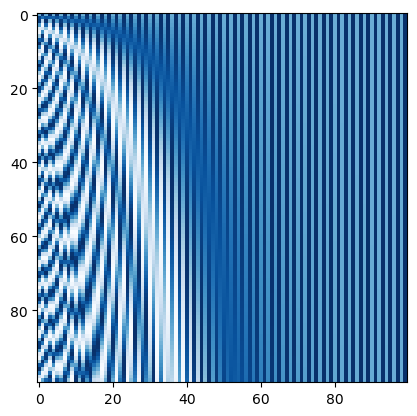

In [3]:
pe = PositionalEmbedding(100, 0)
y = pe.forward(torch.zeros(2, 100, 100))
plt.imshow(y[0], cmap='Blues', interpolation='nearest')
plt.show()

### Then implement the function which calculates attention, given (Q,K,V) as arguments.

In [4]:
torch.tensor([[1,2,3],[4,5,6]]).transpose(0, 1)

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [5]:
def attention(Q, K, V, mask=None, dropout=None):
    #Q, K, V; batch_size, h, seq_length, dk or dv
    rt_d_k = math.sqrt(Q.size(-1))
    scores = torch.matmul(Q, K.transpose(-1,-2)) / rt_d_k
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -math.inf)
        
    p_att = scores.softmax(dim=-1)
    size = V.size()
    if dropout is not None:
        p_att = dropout(p_att)
    
    return torch.matmul(p_att, V), p_att

### Now implement the masking function.

In [6]:
def masked_attention(Q, K, V):
    print(mask)
    return attention(Q, K, V, mask=mask)

### Put it all together to form an entire attention block.

In [7]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.1, h = 8, mask=None):
        super(MultiHeadedAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.h = h
        self.dk = d_model // h
        self.dv = self.dk
        self.attn = None
        self.mask = mask
        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)
        self.W0 = nn.Linear(d_model, d_model)
        
    
    def forward(self, x, mask=None):
        # x; batch_size, seq_length, d_model
        batch_size = x.size(0)
        
        #Linearly project X into Q, K, and V
        queries = self.WQ(x) #batch_size, seq_length, d_model
        keys = self.WK(x)    #batch_size, seq_length, d_model
        values = self.WV(x)  #batch_size, seq_length, d_model
        
        #Split Q, K, and V into multi headed
        queries = queries.view(batch_size, -1, self.h, self.dk).transpose(1,2)
        keys = keys.view(batch_size, -1, self.h, self.dk).transpose(1,2)
        values = values.view(batch_size, -1, self.h, self.dv).transpose(1,2)
        
        #q,k,v ; batch_size, h, seq_length, (dk or dv)
        
        x, self.attn = attention(queries, keys, values, mask, self.dropout)
        #x; batch_size, h, seq_length, dk
        #self.attn; batch_size, 
        
        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.dk * self.h)
        #x; batch_size, seq_length, model_size
        
        return self.W0(x)

### Finish the whole architecture.

#### Decoder Block

In [8]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super(FeedForwardNetwork, self).__init__()
        self.seq = nn.Sequential(nn.Linear(d_model, d_ff),
                                 nn.ReLU(), 
                                 nn.Dropout(dropout),
                                 nn.Linear(d_ff, d_model))
    
    def forward(self, x):
        return self.seq(x)

In [9]:
class AddAndNorm(nn.Module):
    def __init__(self, size):
        super(AddAndNorm, self).__init__()
        self.norm = nn.LayerNorm(size)
    
    def forward(self, x, layer):
        return self.norm(x + layer(x))

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, hidden_layers=2048, dropout=0.1, h=8):
        super(DecoderBlock, self).__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadedAttention(d_model, dropout, h)
        self.ffn = FeedForwardNetwork(d_model, hidden_layers, dropout)
        
        
    def forward(self, x, mask=None):
        base_mask = torch.tril(torch.ones(x.size(-2), x.size(-2))).to(x.device)
        if mask is not None:
            base_mask = mask*base_mask
        x = self.ln1(x + self.mha(x, base_mask))
        x = self.ln2(x + self.ffn(x))
        return x

#### Decoder Stack

In [11]:
class DecoderStack(nn.Module):
    def __init__(self, d_model, N=8, hidden_layers=2048, dropout=0.1, h=8):
        super(DecoderStack, self).__init__()
        self.decoder_blocks = nn.ModuleList([copy.deepcopy(DecoderBlock(d_model, hidden_layers, dropout, h)) for x in range(N)])
    
    def forward(self, x, mask=None):
        for block in self.decoder_blocks:
            x = block(x, mask)
        return x

#### Decoder only transformer
Learned Embeddings -> +Positional embeddings -> Decoder Block (*N) -> Linear -> Softmax -> Output probabilities

In [12]:
class DecoderTransformer(nn.Module):
    def __init__(self, d_model, vocab, N=8, ffl=2048, dropout=0.1, h=8):
        super(DecoderTransformer, self).__init__()
        assert d_model % h == 0
        self.learned_embeddings = nn.Embedding(vocab, d_model)
        self.positional_embedding = PositionalEmbedding(d_model, dropout=dropout)
        self.decoder_stack = DecoderStack(d_model, N=N, hidden_layers=ffl, dropout=dropout, h=h)
        self.lin = nn.Linear(d_model, vocab)
    
    
    def forward(self, x, mask=None):
        #x; batch_size, seq_length, vocab_len
        embedding = self.learned_embeddings(x) #batch_size, seq_length, d_model
        pos_embedding = self.positional_embedding(embedding) #batch_size, seq_length, d_model
        final_embedding = self.decoder_stack(pos_embedding) #batch_size, seq_length, d_model
        logits = self.lin(final_embedding) #.softmax(dim=-1) #batch_size, seq_length, vocab_len
        return logits

### Training on the reverse dataset

In [13]:
class ReverseDataset(Dataset):
    def __init__(self, length):
        self.length = length
        self.size = 10**length # total number of possible combinations

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x = torch.randint(10, size=(self.length,), dtype=torch.long)
        y = torch.flip(x,(-1,))
        return x, y

In [14]:
rd = ReverseDataset(6)

batch_size = 2048
train_loader = DataLoader(
    rd, shuffle=True, pin_memory=True, batch_size=batch_size
)
device =torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: mps


#### Functional optimiser

In [15]:
model = DecoderTransformer(
  d_model=128, 
  vocab=10, 
  N=2,
  ffl=512, 
  dropout=0.1, 
  h=4
).to(device).train()

def train(model):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    max_epochs = 1
    losses = [];
    for epoch in range(max_epochs):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for it, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            logits = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            losses.append(loss.cpu().detach().numpy())

            optimizer.step()
            pbar.set_description(f"epoch {epoch} iter {it}: train loss {loss.item():.5f}")

In [16]:
torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu")

device(type='mps')

#### Wrapper optimiser

In [17]:
class DecoderTransformerWrapper():
    def __init__(self, model):
        self.device = torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu")
        self.decoder_transformer = model.to(self.device)
        self.losses = []

    @classmethod
    def from_parameters(cls, d_model, vocab, ffl_s=None, height=4, heads=8, dropout=0.1):
        #vocab should be a list of allowed values
        if ffl_s is None:
            ffl_s = d_model * 4
        model = DecoderTransformer(
          d_model=d_model, 
          vocab=len(vocab), 
          N=height,
          ffl=ffl_s, 
          dropout=dropout, 
          h=heads
        )
        return cls(model)

    def train(self, train_loader, lr=1e-4, max_epochs=1, loss_fn=nn.CrossEntropyLoss(), test_lambda=None):
        self.decoder_transformer.train()
        optimizer = optim.Adam(self.decoder_transformer.parameters(), lr=lr)
        self.losses = []
        for epoch in range(max_epochs):
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for it, (x, y) in pbar:
                x = x.to(self.device)
                y = y.to(self.device)

                optimizer.zero_grad()

                logits = self.decoder_transformer(x)
                loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
                loss.backward()
                self.losses.append(loss.cpu().detach().numpy())

                pred = logits.argmax(dim=-1)
                if test_lambda is None:
                    correct = (pred == y).type(torch.float).sum().item()
                else:
                    correct = test_lambda(pred, y).type(torch.float).sum().item()
                accuracy = correct / x.size(0)
                optimizer.step()
                pbar.set_description(f"epoch {epoch} iter {it}: train loss {loss.item():.5f}, accuracy {accuracy*100:0.2f}%")
  
    def test(self, test_loader, test_lambda=None):
        self.decoder_transformer.eval()
        correct = 0
        n = 0
        with torch.no_grad():
            pbar = tqdm(enumerate(test_loader), total=len(test_loader))
            for it, (x, y) in pbar:
                x = x.to(self.device)
                y = y.to(self.device)
                n += x.size(0)
                logits = self.decoder_transformer(x)
                pred = logits.argmax(dim=-1)
                if test_lambda is None:
                    correct += (pred == y).type(torch.float).sum().item()
                else:
                    correct += test_lambda(pred, y).type(torch.float).sum().item()
                accuracy = correct / n
                pbar.set_description(f"iter {it}: test accuracy {accuracy*100:.2f}%")    
    def eval(self, x):
        self.decoder_transformer.eval()
        x = x.to(self.device)
        if len(x.size()) == 1:
            x = x.unsqueeze(0)
        with torch.no_grad():
            logits = self.decoder_transformer(x)
        return logits.argmax(dim=-1)
    
    def to(self, device):
        self.device = device
        self.decoder_transformer.to(device)


if 'handler' in locals():
    handler = DecoderTransformerWrapper(handler.decoder_transformer)

In [18]:
handler = DecoderTransformerWrapper.from_parameters(d_model=128,
                                    vocab=range(10),
                                    height=2,
                                    ffl_s=512, 
                                    dropout=0.1, 
                                    heads=4)
handler.to(torch.device('cpu'))
handler.train(train_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

epoch 0 iter 488: train loss 1.22697, accuracy 89.93%: 100%|██████████| 489/489 [02:50<00:00,  2.87it/s]


In [19]:
test_loader = DataLoader(
    rd, shuffle=True, pin_memory=True, batch_size=1024
)
handler.test(test_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

iter 399: test accuracy 100.00%:  41%|████      | 400/977 [00:22<00:32, 17.92it/s]
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 